# Data Imputation


## Importing libraries and data

In [1]:
# loading the required packages
import time
import psutil
import multiprocessing as mp

# system & general libraries
import sys
import warnings
warnings.filterwarnings('ignore')
sys.setrecursionlimit(1000000)

# pre-processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# imputation libraries
from missingpy import MissForest

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# check the number of cores & memory usage
num_cores = mp.cpu_count()
print("this kernel has "+str(num_cores)+" cores")
print("memory usage :",psutil.virtual_memory())

this kernel has 4 cores
memory usage : svmem(total=17066516480, available=7640903680, percent=55.2, used=9425612800, free=7640903680)


In [7]:
# importing the data
acc_info = pd.read_csv('./Accident_Information.csv')
vehicle_info = pd.read_csv('./Vehicle_Information.csv', encoding='ISO-8859-1')
# for checking the virtual memory available
print("memory usage after importing data :\n\n",psutil.virtual_memory())

memory usage after importing data :

 svmem(total=17066516480, available=5157724160, percent=69.8, used=11908792320, free=5157724160)


In [8]:
# getting preliminary insights from accident data
acc_info.shape
acc_info.head()
acc_info.info()
acc_info.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047256 entries, 0 to 2047255
Data columns (total 34 columns):
Accident_Index                                 object
1st_Road_Class                                 object
1st_Road_Number                                float64
2nd_Road_Class                                 object
2nd_Road_Number                                float64
Accident_Severity                              object
Carriageway_Hazards                            object
Date                                           object
Day_of_Week                                    object
Did_Police_Officer_Attend_Scene_of_Accident    float64
Junction_Control                               object
Junction_Detail                                object
Latitude                                       float64
Light_Conditions                               object
Local_Authority_(District)                     object
Local_Authority_(Highway)                      object
Location_Easting_OS

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Speed_limit,Year
count,2.047254e+06,2.029663e+06,2.046978e+06,2.047082e+06,2.047092e+06,2.047092e+06,2.047081e+06,2.047256e+06,2.047256e+06,2.044336e+06,2.043696e+06,2.047219e+06,2.047256e+06
mean,9.921051e+02,3.728153e+02,1.202319e+00,5.255978e+01,4.414462e+05,2.968855e+05,-1.410155e+00,1.345843e+00,1.833525e+00,1.041707e-02,7.518021e-01,3.884360e+01,2.010524e+03
std,1.809408e+03,1.287796e+03,4.081935e-01,1.445506e+00,9.549620e+04,1.605273e+05,1.403532e+00,8.179627e-01,7.150543e-01,1.351126e-01,1.835289e+00,1.414791e+01,3.765624e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,4.991294e+01,6.495000e+04,1.029000e+04,-7.516225e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.005000e+03
25%,0.000000e+00,0.000000e+00,1.000000e+00,5.148540e+01,3.780635e+05,1.777568e+05,-2.329610e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01,2.007000e+03
50%,1.180000e+02,0.000000e+00,1.000000e+00,5.223758e+01,4.430500e+05,2.611835e+05,-1.362233e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01,2.010000e+03
75%,7.020000e+02,0.000000e+00,1.000000e+00,5.345590e+01,5.242982e+05,3.956100e+05,-2.052600e-01,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,5.000000e+01,2.014000e+03
max,9.999000e+03,9.999000e+03,3.000000e+00,6.075754e+01,6.555400e+05,1.208800e+06,1.762010e+00,9.300000e+01,6.700000e+01,2.000000e+00,8.000000e+00,7.000000e+01,2.017000e+03


In [9]:
# getting preliminary insights from vehicle data
vehicle_info.shape
vehicle_info.head()
vehicle_info.info()
vehicle_info.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2177205 entries, 0 to 2177204
Data columns (total 24 columns):
Accident_Index                      object
Age_Band_of_Driver                  object
Age_of_Vehicle                      float64
Driver_Home_Area_Type               object
Driver_IMD_Decile                   float64
Engine_Capacity_.CC.                float64
Hit_Object_in_Carriageway           object
Hit_Object_off_Carriageway          object
Journey_Purpose_of_Driver           object
Junction_Location                   object
make                                object
model                               object
Propulsion_Code                     object
Sex_of_Driver                       object
Skidding_and_Overturning            object
Towing_and_Articulation             object
Vehicle_Leaving_Carriageway         object
Vehicle_Location.Restricted_Lane    float64
Vehicle_Manoeuvre                   object
Vehicle_Reference                   int64
Vehicle_Type            

,Age_of_Vehicle,Driver_IMD_Decile,Engine_Capacity_.CC.,Vehicle_Location.Restricted_Lane,Vehicle_Reference,Year
count,1.819056e+06,1.442393e+06,1.911344e+06,2.175888e+06,2.177205e+06,2.177205e+06
mean,7.108167e+00,5.387559e+00,2.042234e+03,1.073042e-01,1.553405e+00,2.010934e+03
std,4.725886e+00,2.821651e+00,1.950143e+03,8.799644e-01,7.752484e-01,3.694375e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.004000e+03
25%,3.000000e+00,3.000000e+00,1.299000e+03,0.000000e+00,1.000000e+00,2.008000e+03
50%,7.000000e+00,5.000000e+00,1.598000e+03,0.000000e+00,1.000000e+00,2.011000e+03
75%,1.000000e+01,8.000000e+00,1.997000e+03,0.000000e+00,2.000000e+00,2.014000e+03
max,1.110000e+02,1.000000e+01,9.600000e+04,9.000000e+00,9.100000e+01,2.016000e+03


In [10]:
# merging the two datasets 
acc_vehicle_info = pd.merge(vehicle_info, acc_info, how = 'inner', on = 'Accident_Index')

In [12]:
# removing some of the un-necessary columns
mod_acc_vehicle_info = acc_vehicle_info.drop(['1st_Road_Class', '1st_Road_Number', '2nd_Road_Class', '2nd_Road_Number','Carriageway_Hazards', 'Date', 'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident','Latitude','Local_Authority_(District)', 'Local_Authority_(Highway)','Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude','LSOA_of_Accident_Location','Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Police_Force','Special_Conditions_at_Site', 'Speed_limit','Year_y', 'InScotland','Driver_Home_Area_Type', 'Driver_IMD_Decile','Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'Journey_Purpose_of_Driver','make', 'model','Propulsion_Code','Vehicle_Leaving_Carriageway','Vehicle_Location.Restricted_Lane','Vehicle_Reference', 'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive','Year_x'], axis = 1)
mod_acc_vehicle_info.head()

,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Engine_Capacity_.CC.,Junction_Location,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Manoeuvre,X1st_Point_of_Impact,...,Junction_Control,Junction_Detail,Light_Conditions,Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Time,Urban_or_Rural_Area,Weather_Conditions
0,200501BS00002,36 - 45,3.0,8268.0,Leaving roundabout,Male,None,No tow/articulation,Slowing or stopping,Nearside,...,Auto traffic signal,Crossroads,Darkness - lights lit,1,1,Dry,Dual carriageway,17:36,Urban,Fine no high winds
1,200501BS00003,26 - 35,5.0,8300.0,Not at or within 20 metres of junction,Male,None,No tow/articulation,Going ahead right-hand bend,Nearside,...,Data missing or out of range,Not at junction or within 20 metres,Darkness - lights lit,1,2,Dry,Single carriageway,00:15,Urban,Fine no high winds
2,200501BS00004,46 - 55,4.0,1769.0,Not at or within 20 metres of junction,Female,None,No tow/articulation,Going ahead other,Front,...,Data missing or out of range,Not at junction or within 20 metres,Daylight,1,1,Dry,Single carriageway,10:35,Urban,Fine no high winds
3,200501BS00005,46 - 55,10.0,85.0,Not at or within 20 metres of junction,Male,Skidded,No tow/articulation,Going ahead other,Front,...,Data missing or out of range,Not at junction or within 20 metres,Darkness - lighting unknown,1,1,Wet or damp,Single carriageway,21:13,Urban,Fine no high winds
4,200501BS00006,46 - 55,1.0,2976.0,Not at or within 20 metres of junction,Male,None,No tow/articulation,Moving off,Did not impact,...,Data missing or out of range,Not at junction or within 20 metres,Daylight,1,2,Wet or damp,Single carriageway,12:40,Urban,Raining no high winds


## some useful functions

In [13]:
## dropping bad rows and columns
def drop_useless_rows(df,threshold = 0.8, target = None):
    bad_rows = df.loc[df.isnull().sum(axis = 1)/mod_acc_vehicle_info.shape[1]>= threshold]
    mod_df = df.drop(bad_rows.index, axis = 0)
    if target != None:
        class0 = len(bad_rows[bad_rows[target] == 0])
        class1 = bad_rows[target].value_counts().values[1]
        class0_pc, class1_pc = class0/len(df), class1/len(df)
        print("class0 dropped :", class0)
        print('class0 drop %.3f '% (class0_pc*100)+' %')
        print("class1 dropped :", class1)
        print('class1 drop %.3f ' % (class1_pc*100)+' %')
    return mod_df

def drop_useless_cols(df, threshold = 0.4):
    columns = df.columns
    bad_cols = []
    for col in columns:
        if(df[col].isnull().sum()/len(df) >= threshold):
            bad_cols.append(col)
    mod_df = df.drop(bad_cols,axis = 1)
    print('Dropped %d columns out of %d '%(len(bad_cols), len(columns)))
    return mod_df
  

## Replacing various missing value tags with nan values

In [34]:
import time
start = time.time()
miss_tag = ['Data missing or out of range','Unclassified','Not known','Unallocated']
col_names = mod_acc_vehicle_info.columns

for tag in miss_tag:
    for col in col_names:
        mod_acc_vehicle_info.loc[mod_acc_vehicle_info[col]== tag, col] = np.nan

        
end = time.time()

print("exec time :", end - start)

exec time : 14.795485258102417


In [22]:
mod_acc_vehicle_info_2 = drop_useless_rows(mod_acc_vehicle_info, threshold = 0.5, target = None)
mod_acc_vehicle_info_2.columns

Index(['Accident_Index', 'Age_Band_of_Driver', 'Age_of_Vehicle',
       'Engine_Capacity_.CC.', 'Junction_Location', 'Sex_of_Driver',
       'Skidding_and_Overturning', 'Towing_and_Articulation',
       'Vehicle_Manoeuvre', 'X1st_Point_of_Impact', 'Accident_Severity',
       'Junction_Control', 'Junction_Detail', 'Light_Conditions',
       'Number_of_Casualties', 'Number_of_Vehicles', 'Road_Surface_Conditions',
       'Road_Type', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions'],
      dtype='object')

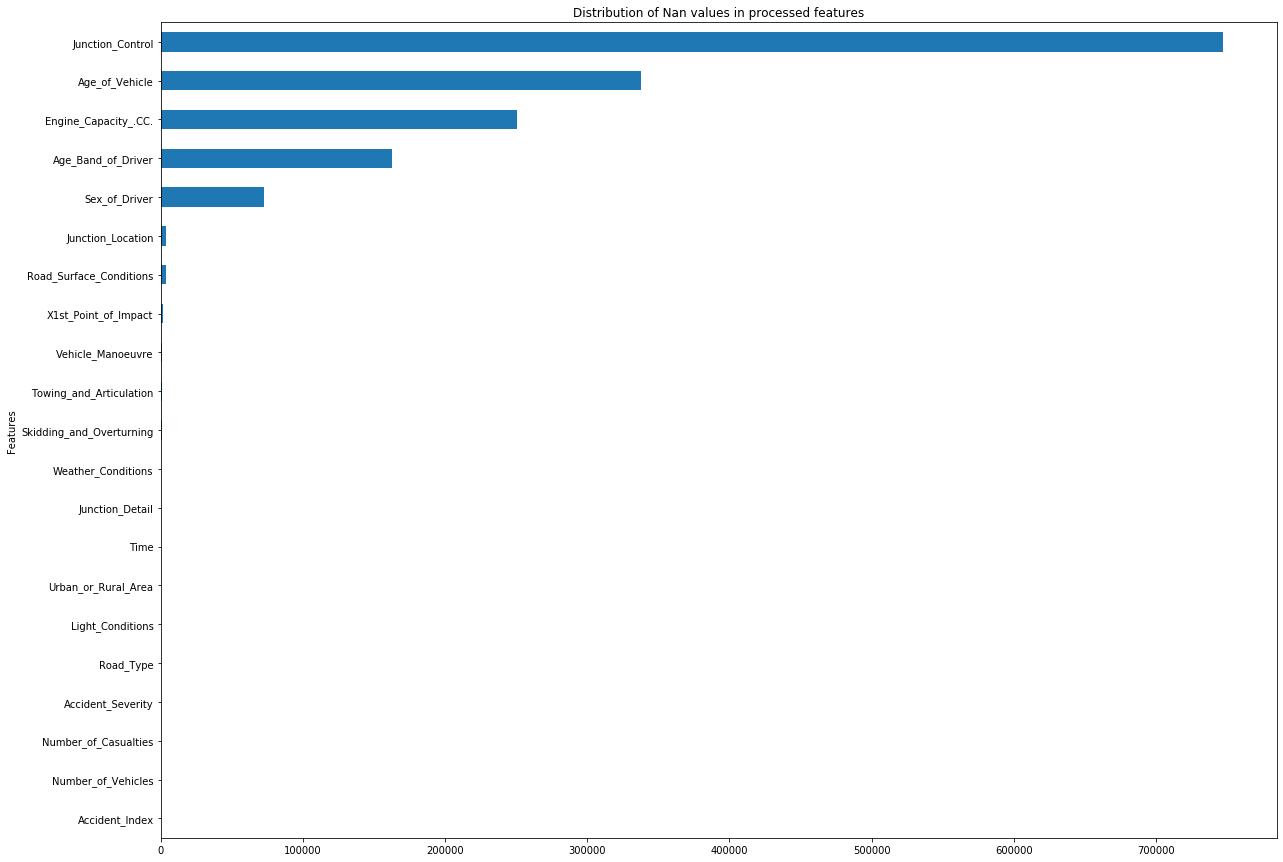

In [19]:
#getting the amount of Nan values in each columns
miss_plot = mod_acc_vehicle_info_2.isnull().sum(axis = 0).sort_values(axis = 0).plot(kind = 'barh', figsize = (20,15), fontsize = 10)
# plotting the mising data as bar plot
miss_plot.set_alpha(2)
miss_plot.set_title('Distribution of Nan values in processed features')
miss_plot.set_ylabel('Features')
plt.show()

In [29]:
# dropping accident_index column and time column
mod_acc_vehicle_info_2 = mod_acc_vehicle_info_2.drop(['Time'], axis = 1)


KeyError: "['Time'] not found in axis"

In [30]:
mod_acc_vehicle_info_2

,Age_Band_of_Driver,Age_of_Vehicle,Engine_Capacity_.CC.,Junction_Location,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Manoeuvre,X1st_Point_of_Impact,Accident_Severity,Junction_Control,Junction_Detail,Light_Conditions,Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Urban_or_Rural_Area,Weather_Conditions
0,36 - 45,3.0,8268.0,Leaving roundabout,Male,None,No tow/articulation,Slowing or stopping,Nearside,Slight,Auto traffic signal,Crossroads,Darkness - lights lit,1.0,1.0,Dry,Dual carriageway,Urban,Fine no high winds
1,26 - 35,5.0,8300.0,Not at or within 20 metres of junction,Male,None,No tow/articulation,Going ahead right-hand bend,Nearside,Slight,NaN,Not at junction or within 20 metres,Darkness - lights lit,1.0,2.0,Dry,Single carriageway,Urban,Fine no high winds
2,46 - 55,4.0,1769.0,Not at or within 20 metres of junction,Female,None,No tow/articulation,Going ahead other,Front,Slight,NaN,Not at junction or within 20 metres,Daylight,1.0,1.0,Dry,Single carriageway,Urban,Fine no high winds
3,46 - 55,10.0,85.0,Not at or within 20 metres of junction,Male,Skidded,No tow/articulation,Going ahead other,Front,Slight,NaN,Not at junction or within 20 metres,Darkness - lighting unknown,1.0,1.0,Wet or damp,Single carriageway,Urban,Fine no high winds
4,46 - 55,1.0,2976.0,Not at or within 20 metres of junction,Male,None,No tow/articulation,Moving off,Did not impact,Slight,NaN,Not at junction or within 20 metres,Daylight,1.0,2.0,Wet or damp,Single carriageway,Urban,Raining no high winds
5,26 - 35,2.0,124.0,Not at or within 20 metres of junction,Female,None,No tow/articulation,Going ahead other,Did not impact,Slight,NaN,Not at junction or within 20 metres,Daylight,1.0,2.0,Wet or damp,Single carriageway,Urban,Raining no high winds
6,26 - 35,NaN,NaN,Approaching junction or waiting/parked at junc...,Male,None,No tow/articulation,Going ahead other,Front,Slight,Give way or uncontrolled,T or staggered junction,Darkness - lights lit,1.0,2.0,Dry,Single carriageway,Urban,Fine no high winds
7,36 - 45,4.0,4266.0,Approaching junction or waiting/parked at junc...,Male,None,No tow/articulation,Parked,Back,Slight,Give way or uncontrolled,T or staggered junction,Darkness - lights lit,1.0,2.0,Dry,Single carriageway,Urban,Fine no high winds
8,66 - 75,16.0,5343.0,Not at or within 20 metres of junction,Male,None,No tow/articulation,Going ahead other,Front,Slight,NaN,Not at junction or within 20 metres,Daylight,2.0,1.0,Dry,Dual carriageway,Urban,Fine no high winds
9,26 - 35,6.0,1988.0,Mid Junction - on roundabout or on main road,Male,None,No tow/articulation,Going ahead other,Front,Slight,Auto traffic signal,Crossroads,Darkness - lights lit,1.0,1.0,Dry,Single carriageway,Urban,Fine no high winds


In [64]:
# practice example
data = { 
    'A':['A1', 'A2', 'A3', 'A4', np.nan],  
    'B':['B1', 'B2', 'B3', np.nan, 'B4'],  
    'C':['C1', 'C2', np.nan, 'C3', 'C3'],  
    'D':['D1', 'D2', 'D2', 'D2', 'D2'],  
    'E':['E1', 'E1', 'E1', 'E1', 'E1'] } 
  
# Convert the dictionary into DataFrame  
df = pd.DataFrame(data) 
col = df.columns
df['B'].unique()

array(['B1', 'B2', 'B3', nan, 'B4'], dtype=object)

In [82]:
# label encoding of all categorical variables with nan values,
# it won't do anything to nan values
def label_encode(df ,cat_columns):
    for col in cat_columns:
        unique_values = df[col].unique()
        for enc in range(len(unique_values)):
            if(unique_values[enc] == np.nan):
                pass
            else:
                df.loc[df[col] == unique_values[enc], col] = enc
    return df
            

In [83]:
label_encode(df, df.columns)

,A,B,C,D,E
0,0,0,0,0,0
1,1,1,1,1,0
2,2,2,NaN,1,0
3,3,NaN,3,1,0
4,NaN,4,3,1,0


## Modelling Age band of drivers

In [68]:
# unique age band of the driver
mod_acc_vehicle_info_2.Age_Band_of_Driver.unique()

array(['36 - 45', '26 - 35', '46 - 55', '66 - 75', '16 - 20', '56 - 65',
       nan, '21 - 25', 'Over 75', '11 - 15', '6 - 10', '0 - 5'],
      dtype=object)

In [69]:
age = 'Age_Band_of_Driver'
mod_acc_vehicle_info_2.ix[mod_acc_vehicle_info_2[age] == '0 - 5', age] = 0
mod_acc_vehicle_info_2.ix[mod_acc_vehicle_info_2[age] == '6 - 10', age] = 1
mod_acc_vehicle_info_2.ix[mod_acc_vehicle_info_2[age] == '11 - 15', age] = 2
mod_acc_vehicle_info_2.ix[mod_acc_vehicle_info_2[age] == '16 - 20', age] = 3
mod_acc_vehicle_info_2.ix[mod_acc_vehicle_info_2[age] == '21 - 25', age] = 4
mod_acc_vehicle_info_2.ix[mod_acc_vehicle_info_2[age] == '26 - 35', age] = 5
mod_acc_vehicle_info_2.ix[mod_acc_vehicle_info_2[age] == '36 - 45', age] = 6
mod_acc_vehicle_info_2.ix[mod_acc_vehicle_info_2[age] == '46 - 55', age] = 7
mod_acc_vehicle_info_2.ix[mod_acc_vehicle_info_2[age] == '56 - 65', age] = 8
mod_acc_vehicle_info_2.ix[mod_acc_vehicle_info_2[age] == '66 - 75', age] = 9
mod_acc_vehicle_info_2.ix[mod_acc_vehicle_info_2[age] == 'Over 75', age] = 10

## Label encoding the other categorical variables

In [98]:
col_no = np.arange(3,13)
col_no1 = np.arange(15,19)
cat_col_no = np.append(col_no, col_no1)
cat_vars = mod_acc_vehicle_info_2.columns[cat_col_no].to_list()
# cat_vars.append(mod_acc_vehicle_info_2.columns[15:19].to_list())
# mod_acc_vehicle_info_2 
print("The categorical variables are :")
cat_vars

The categorical variables are :


['Junction_Location',
 'Sex_of_Driver',
 'Skidding_and_Overturning',
 'Towing_and_Articulation',
 'Vehicle_Manoeuvre',
 'X1st_Point_of_Impact',
 'Accident_Severity',
 'Junction_Control',
 'Junction_Detail',
 'Light_Conditions',
 'Road_Surface_Conditions',
 'Road_Type',
 'Urban_or_Rural_Area',
 'Weather_Conditions']

In [96]:
# label encoding
le_df = label_encode(mod_acc_vehicle_info_2, cat_columns = cat_vars)
le_df

,Age_Band_of_Driver,Age_of_Vehicle,Engine_Capacity_.CC.,Junction_Location,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Manoeuvre,X1st_Point_of_Impact,Accident_Severity,Junction_Control,Junction_Detail,Light_Conditions,Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Urban_or_Rural_Area,Weather_Conditions
0,6,3.0,8268.0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0,0,0,0
1,5,5.0,8300.0,1,0,0,0,1,0,0,NaN,1,0,1.0,2.0,0,1,0,0
2,7,4.0,1769.0,1,1,0,0,2,1,0,NaN,1,1,1.0,1.0,0,1,0,0
3,7,10.0,85.0,1,0,1,0,2,1,0,NaN,1,2,1.0,1.0,1,1,0,0
4,7,1.0,2976.0,1,0,0,0,3,2,0,NaN,1,1,1.0,2.0,1,1,0,1
5,5,2.0,124.0,1,1,0,0,2,2,0,NaN,1,1,1.0,2.0,1,1,0,1
6,5,NaN,NaN,2,0,0,0,2,1,0,2,2,0,1.0,2.0,0,1,0,0
7,6,4.0,4266.0,2,0,0,0,4,3,0,2,2,0,1.0,2.0,0,1,0,0
8,9,16.0,5343.0,1,0,0,0,2,1,0,NaN,1,1,2.0,1.0,0,0,0,0
9,5,6.0,1988.0,3,0,0,0,2,1,0,0,0,0,1.0,1.0,0,1,0,0


## Data Imputation

In [103]:
# using miss forest example

X = [[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [8, 8, 7]]

imputer = MissForest(max_iter=10, decreasing=False, missing_values=np.nan,
             copy=True, n_estimators=100, criterion=('mse', 'gini'),
             max_depth=None, min_samples_split=2, min_samples_leaf=1,
             min_weight_fraction_leaf=0.0, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             bootstrap=True, oob_score=False, n_jobs=-1, random_state= 1,
             verbose=0, warm_start=False, class_weight=None)

X_imp = imputer.fit_transform(X)
X_imp

Iteration: 0
Iteration: 1
Iteration: 2


array([[1.  , 2.  , 3.98],
       [3.  , 4.  , 3.  ],
       [2.95, 6.  , 5.  ],
       [8.  , 8.  , 7.  ]])

In [ ]:
imputer = MissForest(max_iter=10, decreasing=False, missing_values=np.nan,
             copy=True, n_estimators=100, criterion=('mse', 'gini'),
             max_depth=None, min_samples_split=2, min_samples_leaf=1,
             min_weight_fraction_leaf=0.0, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             bootstrap=True, oob_score=False, n_jobs=-1, random_state= 1,
             verbose=0, warm_start=False, class_weight=None)

data_imputed = imputer.fit_transform(le_df, cat_vars = cat_col_no)